# Page rank

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import graphviz as gv

## Network classes

In [3]:
class Page:
    """A class representing a webpage."""
    def __init__(self, name):
        """Constructor method, takes the name of the webpage as an argument."""
        self.name = name
        self.links = []
        
    def __repr__(self):
        """A page is represented by its name."""
        return self.name
    
    def addLinkTo(self, other):
        """Adds a link to another page"""
        self.links.append(other)
        
    def outDegree(self):
        """Returns the amount of links this page has i.e. its out-degree"""
        return len(self.links)

In [13]:
class Network:
    """A class representing a network of webpages"""
    def __init__(self):
        """A network starts without any pages."""
        self.pages = []
        self.counter = 0
    
    def __iter__(self):
        """Iterating over a network is the same as iterating over its pages."""
        return iter(self.pages)
    
    def addPage(self, page: Page):
        """Adds a page to the network"""
        # give the page an id (since the name of the webpage doesn't have to be unique)
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
    def addPages(self, *args):
        """Adds multiple pages to the network"""
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        """Returns the pages in the network."""
        return self.pages
    
    def size(self):
        """Returns the size of the network."""
        return len(self.pages)
    
    def showRanking(self):
        """
        Prints the pages with their corresponding rank. 
        Not sorted on anything in particular, prints in increasing id.
        """
        for page in self:
            print(f'{page.name}: {page.rank}')
            
    # --------------------- VISUALIZATION -------------------
    
    def nxDiGraph(self):
        """Calculates networkx DiGraph"""
        # make a directed graph
        G = nx.DiGraph()
        
        # add all the edges and nodes to it
        for page in self:
            G.add_node(page)
            for other in page.links:
                G.add_edge(page, other)
        
        return G
    
    def plot1(self, names=False):
        """
        Plot using networkx.
        Node size based on *number of links*
        """
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*len(page.links) for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
    
    def plot2(self):
        """Plot using networkx. Node size based on *rank*"""
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*page.rank for page in G.nodes()]
        
        # labels
        labels = {page:page.id for page in G.nodes()}
        
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
        
    def plot0(self):
        """Plot using graphviz"""
        f = gv.Digraph()
        for page in self:
            f.node(str(page))
            for other in page.links:
                f.edge(str(page), str(other))

        return f

### Example

In [14]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")

wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [15]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [16]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [17]:
pages[1].links

[YouTube, Twitter]

In [18]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [19]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [20]:
class PageRanker:
    """A static class for ranking a network."""
    
    @staticmethod
    def rank(network: Network, steps: int, alpha: float):
        """
        Ranks a network via the PageRank algorithm.
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        PageRanker.calculateInitialRanking(network)
        PageRanker.calculateJumpingProbabilities(network)
        
        newRanks = {}
        for _ in range(0, steps):
            for page in network:
                newRanks[page] = 0
                for other in page.links:
                    newRanks[page] += other.rank / page.outDegree()
                newRanks[page] *= alpha
                newRanks[page] += (1-alpha) * page.q
                
        for page in network:
            page.rank = newRanks[page]
    
    @staticmethod
    def calculateInitialRanking(network: Network):
        """
        Calculates an initial ranking for the given network.
        Currently just gives each page a ranking of 1 / size of the network.
        """
        for page in network:
            page.rank = 1 / network.size()
            
    @staticmethod
    def calculateJumpingProbabilities(network: Network):
        """Calculates the probabilities of jumping to each page."""
        for page in network:
            page.q = 1 / network.size()

### Example

In [21]:
PageRanker.rank(internet, 1000, 0.5)

In [22]:
internet.showRanking()

YouTube: 0.3333333333333333
Wikipedia: 0.3333333333333333
Twitter: 0.3333333333333333


In [23]:
PageRanker.rank(california, 100, 0.5)

In [24]:
california.showRanking()

http://www.berkeley.edu/: 0.00010347682119205298
http://www.caltech.edu/: 0.00010347682119205298
http://www.realestatenet.com/: 0.00010347682119205298
http://www.ucsb.edu/: 0.00010347682119205297
http://www.washingtonpost.com/wp-srv/national/longterm/50states/ca.htm: 0.00010347682119205301
http://www-ucpress.berkeley.edu/: 0.00010347682119205298
http://www.ucr.edu/: 0.00010347682119205298
http://www.tegnetcorporation.com/: 0.00010347682119205298
http://www.research.digital.com/SRC/virtual-tourist/California.html: 0.00010347682119205298
http://www.leginfo.ca.gov/calaw.html: 5.173841059602649e-05
http://www.csun.edu/: 0.00010347682119205298
http://www.calpoly.edu/: 0.00010347682119205298
http://www.calbar.org/: 0.00010347682119205298
http://ideas.uqam.ca/ideas/data/fthcalaec.html: 5.173841059602649e-05
http://www.sen.ca.gov/: 0.00010347682119205298
http://www.csupomona.edu/: 5.173841059602649e-05
http://www.csuchico.edu/: 5.173841059602649e-05
http://www.calacademy.org/: 0.00010347682119

http://www-marine.stanford.edu/HMSweb/organizations.html: 0.00010347682119205298
http://city-blockbuster.lycos.com/west/MontereyCA.html: 5.173841059602649e-05
http://humanitas.ucsb.edu/shuttle/eng-mod.html: 5.173841059602649e-05
http://kings.k12.ca.us/~dlehar/: 5.173841059602649e-05
http://www.cam.org/~java/ww/links.htm: 5.173841059602649e-05
http://www.sp.nps.navy.mil//npsarc/k6ly.html: 5.173841059602649e-05
http://www.global.org/bfreed/heckifiknow/kindred.html: 5.173841059602649e-05
http://www.asiadragons.com/education/north_america/united_states/california/: 0.00010347682119205298
http://www.ucsc.edu/library/science/embark/index.html: 0.00010347682119205298
http://www.levity.com/corduroy/millerh.htm: 5.173841059602649e-05
http://www.islandnet.com/~pjhughes/sci2.htm: 5.173841059602649e-05
http://jobs.monterey.edu/: 5.173841059602649e-05
http://infotech.monterey.edu/netcom/: 5.173841059602649e-05
http://infotech.monterey.edu: 5.173841059602649e-05
http://infotech.monterey.edu/magazine

http://home.cray.com/~mclark/: 0.00010347682119205298
http://gola.miningco.com/msub20.htm: 0.00010347682119205298
http://whatsonthe.net/webcamks.htm: 5.173841059602649e-05
http://www.happycampers.net/reg_dir/l_0308.html: 0.00010347682119205298
http://www.bbod.com/: 0.00010347682119205298
http://www.mitchell.demon.nl/cam.htm: 5.173841059602649e-05
http://www.brnet.com/ae.html: 5.173841059602649e-05
http://www.homesecretary.com/weblinks.htm: 0.00010347682119205298
http://www.kfi640.com/camdemonium/lacams.html: 0.00010347682119205298
http://ken.iwaynet.net/camwest.html: 0.00010347682119205298
http://www.intelligent.com.au/webcam/usaweb.htm: 5.173841059602649e-05
http://www.oneweb.com/infoctrs/beaches.html: 5.173841059602649e-05
http://chili.rt66.com/ozone/west.htm: 5.173841059602649e-05
http://www.wcco.com/news/newsstand/netcameras.html: 5.173841059602649e-05
http://www.a2znet.com/cams.html: 5.173841059602649e-05
http://www.calpoly.edu/~rkaessne/Surf.html: 5.173841059602649e-05
http://our

http://www.gopnet.org/aux1.html: 5.173841059602649e-05
http://home.earthlink.net/~danwen/: 5.173841059602649e-05
http://www.rpk.org/kfcr/cr.htm: 0.00010347682119205298
http://home.earthlink.net/~mpettengill/links.htm: 5.173841059602649e-05
http://biggulp.callamer.com/~republic/: 0.00010347682119205298
http://www.savenet.org/others.htm: 5.173841059602649e-05
http://www.envista.com/piercecampaign/links.html: 0.00010347682119205298
http://web.aimnet.com/~jbv/conservative_sites.html: 0.00010347682119205298
http://www.bluesquare.com/fuller/team.html: 5.173841059602649e-05
http://www.cisnet.ro/adrese-utile/guverne.html: 5.173841059602649e-05
http://w3.one.net/~dbarker/v3/blood-archive.html: 5.173841059602649e-05
http://www.rightnow.org/republican_links.html: 0.00010347682119205298
http://www.soltec.net/~cknite/cif/a-e.html: 5.173841059602649e-05
http://www.webmill.com/WebSleuth/new/republican.shtml: 5.173841059602649e-05
http://www.sccu.edu/republicans/index.html: 0.00010347682119205298
http

http://socalink.com/Reviews/Science/Planet_Earth/Resources/index.latimes.html: 5.173841059602649e-05
http://www.themall.net/links/index.html: 5.173841059602649e-05
http://truckeetahoe.com/: 0.00010347682119205298
http://home.sprynet.com/sprynet/keithco/cube-trw.htm: 0.00010347682119205298
http://eci2.ucsb.edu/~tbmaddux/h_noframe.html: 0.00010347682119205298
http://www-ccs.ucsd.edu/oilspill/: 0.00010347682119205298
http://www.real-surfing.com/weather/southern_california.html: 0.00010347682119205298
http://www.sdsc.edu/surf/: 5.173841059602649e-05
http://www.indigo.ie/imagine/irish-surfing/links.htm: 0.00010347682119205298
http://www.fountainhead.com/super/weather.html: 0.00010347682119205298
http://www.lib.noaa.gov/docs/windandsea6.html: 0.00010347682119205298
http://meteora.ucsd.edu/~niklas/: 0.00010347682119205298
http://www.rain.org/~hanke/qk.html: 0.00010347682119205298
http://www.surfrider.org/Cal5.htm: 5.173841059602649e-05
http://sio.ucsd.edu/supp_groups/development/sioprevu.htm:

## Visualization of (small) networks

### With networkx

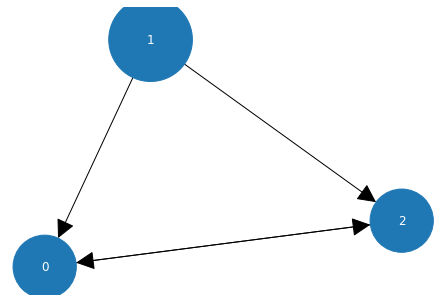

In [15]:
# size based on links
internet.plot1()

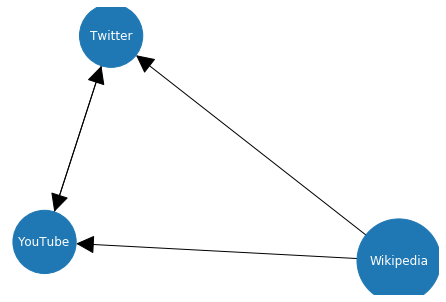

In [16]:
# plot with names (works in this case, but often labels are too large for the nodes)
internet.plot1(names=True)

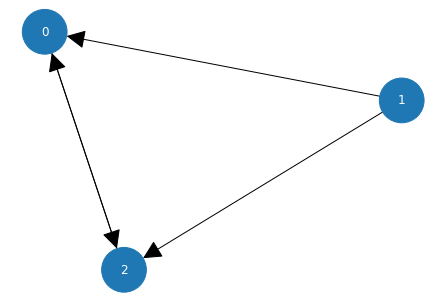

In [17]:
#size based on rank
internet.plot2()

### With graphviz

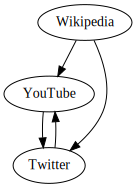

In [18]:
internet.plot0()